## Outliers in Text Corpora
- usually text corpora contain a mix of exhaustive as well as non-exhaustive documents
- such a mix of wide genres and themes of documents extensively increase the occurances of anomalies, which need to be flagged for deployed ML systems
- this notebook studies and implements the same to analyze anomalous texts and emerging themes in large NLP corpora 
- the workflow is based on: Transformers, cleablab, UMAP, and c-TF-IDF from BERTopic
    1. `AutoTokenizer` and `AutoModel` submodules from `transformers` are used to obtain accurate tokenized representations from the raw text belonging to different genres and themes and retrieve the relevant model architecture, using a pretrained tokenizer+model from HuggingFaceHub
    2. PyTorch datasets are obtained from preprocessed text datasets from HuggingFaceHub, and operations are performed over the dataset using `torch`
    3. `OutOfDistribution` submodule of `cleanlab` is used to determine the outliers based on outlier scores using a nearest neighbour estimator
    4. the results are further processed and visualized to conclude the anomaly trends using `UMAP` and class based `TF-IDF` to further filter out the outliers using the weights of words/phrased in the corpus
    5. once the anomalous genres are clustered, topics within them are identified depicting out-of-distribution topics

In [2]:
import cleanlab
import datasets
import hdbscan
import nltk
import matplotlib.pyplot as plt
import numpy as np
import re
import torch

from cleanlab.outlier import OutOfDistribution
from datasets import load_dataset, concatenate_datasets
from IPython.display import display
from sklearn.metrics import precision_recall_curve
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel
from umap import UMAP

try:
    nltk.corpus.stopwords.words
except:
    nltk.download('stopwords')

/home/paxx/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-06 08:01:16.126652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-06 08:01:16.126695: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
datasets.logging.set_verbosity_error()

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)

#### MultiNLI DataSet
- Natural Language Inference (also known Recognizing Textual Entailment) is a task to determine whether 
    - the given `hypothesis` follows the `premise` (Entailment)
    - the given `hypothesis` doesnt follow the `premise` (Contradiction)
    - or the relation between the `hypothesis` and the `premise` is undetermined (Neutral)
- NLI problem can be further rephrased as classification of the hypothesis into three classes based on premise (proposition) namely entailment, contradiction and neutral
- In simpler words, we have to determine whether the hypothesis is true, while all we know about the subject/topic is the premise
- Among other corpora, MultiNLI is a crowdsourced, multi-genred corpus for training NLI systems
- MultiNLI dataset can be fetched using the HuggingFaceHub `dataset` API for this notebook
- the corpus is split into a single training set and two validation sets
    - training set is sourced from 5 genres `[fiction, government, slate, telephone, travel]`
    - `matched training set` is sourced from same 5 genres as of training set
    - `mismatched training set` is sourced from other genres not present in training set `[nineeleven, facetoface, letters, oup, verbatim]`

#### Data Preprocessing
1. removing unused features
2. removing any entailment labels in the dataset
3. excluding genre information, as model does not require the same, but is used for further evaluation  

In [4]:
def preprocess_datasets(*datasets, 
                        sample_sizes = [45000, 9000, 9000],
                        columns_to_remove = ['premise_binary_parse', 'premise_parse', 'hypothesis_binary_parse', 'hypothesis_parse', 'promptID', 'pairID', 'label'],):

    f = lambda ex: ex["label"] != -1
    datasets = [dataset.filter(f) for dataset in datasets]

    # Sample a subset of the data
    assert len(sample_sizes) == len(datasets), "Number of datasets and sample sizes must match"
    datasets = [
        dataset.shuffle(seed=SEED).select([idx for idx in range(sample_size)])
        for dataset, sample_size in zip(datasets, sample_sizes)
    ]
    
    # Remove columns
    datasets = [data.remove_columns(columns_to_remove) for data in datasets]

    return datasets

train_data = load_dataset("multi_nli", split="train")
val_matched_data = load_dataset("multi_nli", split="validation_matched")
val_mismatched_data = load_dataset("multi_nli", split="validation_mismatched")

train_data, val_matched_data, val_mismatched_data = preprocess_datasets(train_data, val_matched_data, val_mismatched_data)

In [5]:
print("Training data")
print(f"Genres: {np.unique(train_data['genre'])}")
display(train_data.to_pandas().head())

print("Validation matched data")
print(f"Genres: {np.unique(val_matched_data['genre'])}")
display(val_matched_data.to_pandas().head())

print("Validation mismatched data")
print(f"Genres: {np.unique(val_mismatched_data['genre'])}")
display(val_mismatched_data.to_pandas().head())

Training data
Genres: ['fiction' 'government' 'slate' 'telephone' 'travel']


,premise,hypothesis,genre
0,I'll hurry over that part.,"""I'll be quick with that part.""",fiction
1,Shall I tell you why you have been so vehement...,I can tell you why you're being so vehement ag...,fiction
2,well you know that brings up the interesting s...,It begs the question of who gets to say what t...,telephone
3,A great Sather made the sun remain in one plac...,It got too hot when a Sather kept the sun in o...,fiction
4,"Of course, it will be generally known to-morro...","The news was about to break, and John had anno...",fiction


Validation matched data
Genres: ['fiction' 'government' 'slate' 'telephone' 'travel']


,premise,hypothesis,genre
0,Nobody knows much about the early Etruscans.,"Nobody knows about them, because they didn't e...",travel
1,Improved products and services Initiate acti...,Managed risks lead to new products,government
2,The WP runs a piece inside reporting that duri...,The WP runs a program to help the homeless,slate
3,She didn't listen.,She didn't listen when he was speaking.,fiction
4,It has served as a fortress for the Gallo-Roma...,The fortress was built by the medieval French ...,travel


Validation mismatched data
Genres: ['facetoface' 'letters' 'nineeleven' 'oup' 'verbatim']


,premise,hypothesis,genre
0,One of the most significant changes in retail ...,Vender managed inventory was first invented in...,oup
1,From Home Work to Modern Manufacture,Modern manufacturing has changed over time.,oup
2,"By this time, Bin Ladin was well-known and a s...",Bin Laden had yet to make a name for himself a...,nineeleven
3,"The reception is scheduled for Thursday, April...",The reception is scheduled to go for less than...,letters
4,Though novel for its open endorsement of indis...,Bin Ladin had ignored the United States until ...,nineeleven


#### Sentence Embedding
- we are using a pretrained `SentenceTransformer` to transform the sentence pairs of hypothesis and premise into vector embeddings
- workflow for the same is as follows
    1. both sentences are processed by a Siamese-BERT-Network followed by mean pooling 
    2. further the `pooled_premise` and `pooled_hypothesis` are used to transform the information into vectorized form `|pooled_hypothesis - pooled_premise|`
    3. lastly, a Softmax classifier is put on top of the vector embeddings since there are multiple classes to classify the embeddings into
    4. to wrap all this up, a pretrained tokenizer+model is used from HuggingFaceHub to provide token embeddings to the pooling layer of the network

In [6]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # first element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [7]:
def embed_sentence_pairs(dataloader, tokenizer, model, disable_tqdm=False):
    premise_embeddings  = []
    hypothesis_embeddings = []
    feature_embeddings = []

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    model.eval()

    loop = tqdm(dataloader, desc=f"Embedding sentences...", disable=disable_tqdm)
    for data in loop:

        premise, hypothesis = data['premise'], data['hypothesis']
        encoded_premise, encoded_hypothesis = (
            tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
            for sentences in (premise, hypothesis)
        )

        # compute token embeddings
        with torch.no_grad():
            encoded_premise = encoded_premise.to(device)
            encoded_hypothesis = encoded_hypothesis.to(device)
            model_premise_output = model(**encoded_premise)
            model_hypothesis_output = model(**encoded_hypothesis)

        # perform pooling
        pooled_premise = mean_pooling(model_premise_output, encoded_premise['attention_mask']).cpu().numpy()
        pooled_hypothesis = mean_pooling(model_hypothesis_output, encoded_hypothesis['attention_mask']).cpu().numpy()
    
        premise_embeddings.extend(pooled_premise)
        hypothesis_embeddings.extend(pooled_hypothesis)

        
    # concatenate premise and hypothesis embeddings, as well as their absolute difference
    feature_embeddings = np.concatenate(
        [
            np.array(premise_embeddings),
            np.array(hypothesis_embeddings),
            np.abs(np.array(premise_embeddings) - np.array(hypothesis_embeddings))
        ],
        axis=1
    )
    # feature_embeddings = normalize(feature_embeddings, norm='l2', axis=1)
    return feature_embeddings

In [8]:
# pretrained model from 'hugging face' 
model_name = 'sentence-transformers/all-MiniLM-L6-v2'

# another transformer trained on multiNLI
# model_name = 'sileod/roberta-base-mnli'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

batch_size = 64

# loading datasets
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valmatchedloader = DataLoader(val_matched_data, batch_size=batch_size, shuffle=False)
valmismatchedloader = DataLoader(val_mismatched_data, batch_size=batch_size, shuffle=False)


# embeddings
train_embeddings = embed_sentence_pairs(trainloader, tokenizer, model, disable_tqdm=True)
val_matched_embeddings = embed_sentence_pairs(valmatchedloader, tokenizer, model, disable_tqdm=True)
val_mismatched_embeddings = embed_sentence_pairs(valmismatchedloader, tokenizer, model, disable_tqdm=True)

#### Outlier Detection
- with vector embeddings ready, now is the time find the outliers in the training data
- for this we use `OutOfDistribution` class of `cleanlab` to fit a nearest neighbour estimator to the training data
- this returns a outlier score for each example in training data according to its avg distance from K nearest neighbours 
- then with this fitted nearest neightbour estimator, outlier scores are generated for examples in validation data


In [9]:
# outlier scores for training data feature embeddings
ood = OutOfDistribution()
train_outlier_scores = ood.fit_score(features=train_embeddings)

Fitting OOD estimator based on provided features ...


In [10]:
# top outliers in training data
top_train_outlier_idxs = (train_outlier_scores).argsort()[:15]
top_train_outlier_subset = train_data.select(top_train_outlier_idxs)
top_train_outlier_subset.to_pandas().head()

,premise,hypothesis,genre
0,Harley-Davidson has sought to trademark the ru...,Harley-Davidson has sought to trademark the ru...,slate
1,The value of g in the situation described abov...,The value of g in the situation described abov...,government
2,"Well done, Scott!","Well done, Scott!",slate
3,"I'm interested, too. The cantina owner's drawl...",I'm interested too. The cantina owner's drawl ...,fiction
4,Amarillo Dumas Panhandle,Amarillo Dumas Panhandle,telephone


In [11]:
# outlier scores for the feature embeddings in validation set; both matched and mismatched
test_feature_embeddings = np.concatenate([val_matched_embeddings, val_mismatched_embeddings], axis=0)
test_outlier_scores = ood.score(features=test_feature_embeddings)
print(test_outlier_scores)

[0.58687884 0.628484   0.6129401  ... 0.5913148  0.62418294 0.58997643]


- one observation here is that the most of the top outliers are from the `mismatched_genres` validation set
- while, looking at the other end of outliers, which are unlikely to be outliers are from `matched_genre` validation set

In [12]:
# top outliers in validation data
test_data = concatenate_datasets([val_matched_data, val_mismatched_data])
top_outlier_idxs = (test_outlier_scores).argsort()[:20]
top_outlier_subset = test_data.select(top_outlier_idxs)
top_outlier_subset.to_pandas()

,premise,hypothesis,genre
0,"Next bend, back to silver.","Next bend, back to silver.",letters
1,"Hani Hanjour, Khalid al Mihdhar, and Majed Moq...","CAPPS flagged Majed Moqed, Khalid al Mihdhar, ...",nineeleven
2,The space age began with the launch of Sputnik...,In October 1957 the space age started after th...,letters
3,I am inclined to prefer perjink and its deriva...,I do not like perjink or its derivatives.,verbatim
4,The last stages of uploading are like a mental...,The final part of uploading feels like a menta...,fiction
5,"However, when I highlighted antecedent , what ...","When I highlighted the word antecedent, the sy...",verbatim
6,Putting another ply on top the same way create...,There's another problem created when another p...,oup
7,Atone comes from the Middle English at `at' + ...,Middle English at + on is the origin of Atone.,verbatim
8,"Under Boolean algebra , W has the a set that ...",Boolean algebra is formed from the subsets of ...,verbatim
9,Marr sought authorization to scramble the Otis...,Marr asked for permission to scramble the Otis...,nineeleven


In [13]:
# least severe outliers
bottom_outlier_idxs = (-test_outlier_scores).argsort()[:20]
bottom_outlier_subset = test_data.select(bottom_outlier_idxs)
bottom_outlier_subset.to_pandas()

,premise,hypothesis,genre
0,It recalls William Randolph Hearst's castle in...,There is no art or sculptures located there.,travel
1,said San'doro.,San'doro spoke.,fiction
2,The purpose of this paper is to analyze rural ...,Rural delivery is more expensive than city.,government
3,said San'doro.,San'doro whispered.,fiction
4,said San'doro.,San'doro said nothing.,fiction
5,uh-huh well maybe well i've enjoyed talking to...,I liked talking to you.,telephone
6,Answer? said Julius.,Julius asked for an answer.,fiction
7,uh-huh well maybe well i've enjoyed talking to...,I hated talking to you.,telephone
8,Answer? said Julius.,Julius needed an answer right then.,fiction
9,The museum is open from 9am to 1pm and 2 to 5p...,There are no plans to have the museum open on ...,travel


- as observed, the outliers flagged are somewhat misinformative
- given that validation set consists of mismatched genres, different from those of training set, outlier detection on each genre would give better results
- but for the combined validation set, results can be further improved by introducing a threshold to decide the outliers
- in the next cell, we will set a `threshold=2.5`, returning 2.5th percentile of outlier score distribution in training data as threshold
- flagging outliers using this threshold on validation set will include some false positives

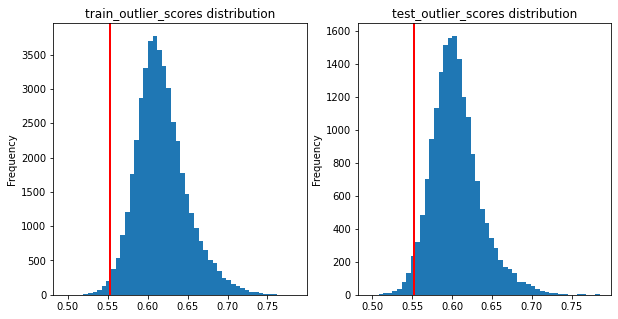

In [14]:
# 2.5 percentile threshold on outlier score
threshold = np.percentile(test_outlier_scores, 2.5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt_range = [min(train_outlier_scores.min(),test_outlier_scores.min()), max(train_outlier_scores.max(),test_outlier_scores.max())]

axes[0].hist(train_outlier_scores, range=plt_range, bins=50)
axes[0].set(title='train_outlier_scores distribution', ylabel='Frequency')
axes[0].axvline(x=threshold, color='red', linewidth=2)
axes[1].hist(test_outlier_scores, range=plt_range, bins=50)
axes[1].set(title='test_outlier_scores distribution', ylabel='Frequency')
axes[1].axvline(x=threshold, color='red', linewidth=2)

In [15]:
# false positives captured
sorted_ids = test_outlier_scores.argsort()
outlier_scores = test_outlier_scores[sorted_ids]
outlier_ids = sorted_ids[outlier_scores < threshold]

selected_outlier_subset = test_data.select(outlier_ids)
selected_outlier_subset.to_pandas().tail(15)

,premise,hypothesis,genre
435,oh i did and i laughed real hard when i took i...,I had a good laugh when I took it for the two ...,telephone
436,He died in a ferryboat accident on Lake Victor...,Bin Ladin kidnapped a man riding on Lake Victo...,nineeleven
437,Does anyone know what happened to chaos?,I know what happened to chaos.,slate
438,"By 10:45 there was, however, another set of fi...",The fighters in the air over Washington at 10:...,nineeleven
439,One opportunist who stayed was Octavius Decatu...,One opportunist who stayed went by the name Oc...,travel
440,We are also organizing an IU Periodontal Alumn...,The IU Periodontal Alumni Association was form...,letters
441,I thought it was lacquer thinner.,"I didn't think it was at first, but it turns o...",facetoface
442,Lean retailing itself implies a dramatic reduc...,Lean retailing calls for an inventory reductio...,oup
443,The space age began with the launch of Sputnik...,Sputnik's launch took many years to plan.,letters
444,Recall how Sophie satisfied both teddy bear's ...,One lollipop was enough for both the teddy bea...,oup


#### Clustering Outliers
- in the mismatched validation set, clustering outliers will give a better idea about topics in mismatched genres
- to implement, using a density based clustering would handle the noise in selected outlier, for ex HDBSCAN
- since HDBSCAN doesnt give good performance over a high dimensional data, a preprocessing step of dimensionality reduction will be included before clustering using UMAP (one of the techniques of dimensionality reduction)

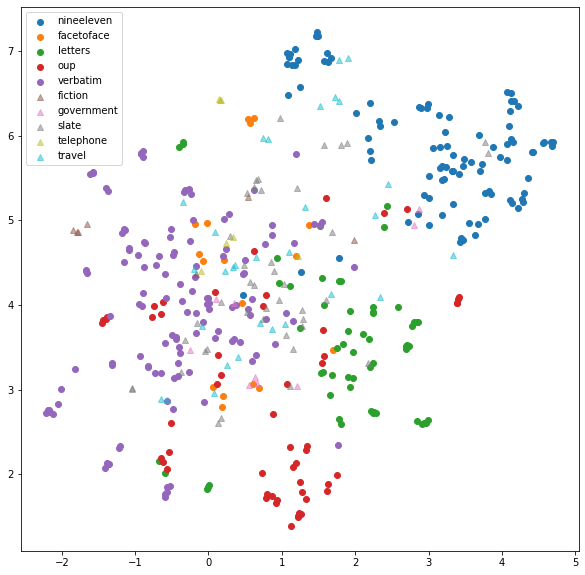

In [16]:
selected_outlier_subset_embeddings = test_feature_embeddings[outlier_ids]

# dimensionality reduction with UMAP
umap_fit = UMAP(n_components=2, n_neighbors=8, random_state=SEED)
selected_outlier_subset_embeddings_umap = umap_fit.fit_transform(selected_outlier_subset_embeddings)

mismatched_labels = {"nineeleven": 0, "facetoface": 1, "letters": 2, "oup": 3, "verbatim": 4}
matched_labels = {"fiction": 5, "government": 6, "slate": 7, "telephone": 8, "travel": 9}
labels_dict = {**mismatched_labels, **matched_labels}
genre_labels = np.array([labels_dict.get(x, 0) for x in selected_outlier_subset["genre"]])

# plotting reduced embeds
plt.figure(figsize=(10, 10))
x_plot, y_plot = selected_outlier_subset_embeddings_umap[:, 0], selected_outlier_subset_embeddings_umap[:, 1]

for i, genre in enumerate(labels_dict.keys()):
    x, y = x_plot[genre_labels == i], y_plot[genre_labels == i]
    if genre in mismatched_labels:
        # mismatched=>solid circles
        plt.scatter(x, y, label=genre)
    else:
        # matched=>transparent triangles
        plt.scatter(x, y, label=genre, alpha=0.5, marker="^")
plt.legend()

- mismatched genres cluster together decently, although there are overlaps of some genres
- best approximation would be to set a smaller minimum cluster size and allow more localized clusters
- sift out smaller local clusters to visualize different topics within a genre

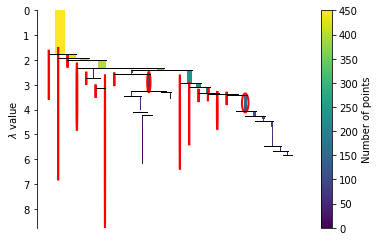

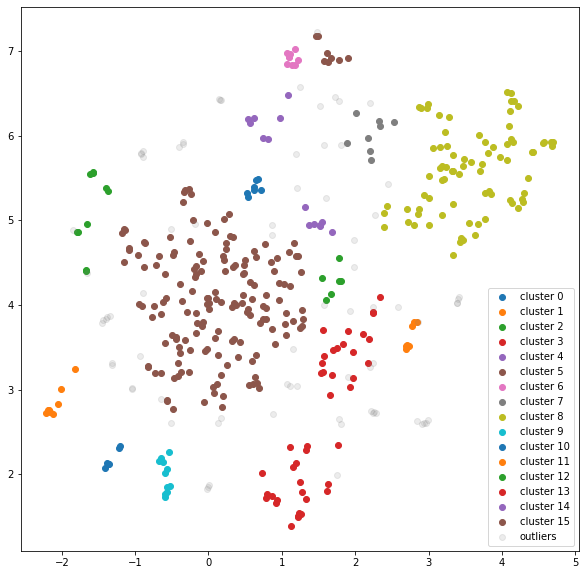

In [17]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=6, min_samples=4)
clusterer.fit(selected_outlier_subset_embeddings_umap)
cluster_labels = clusterer.labels_

clusterer.condensed_tree_.plot(select_clusters=True)

# plot each set of points in a different color
plt.figure(figsize=(10, 10))
for i in np.unique(cluster_labels):
    if i != -1:
        x, y = x_plot[cluster_labels == i], y_plot[cluster_labels == i]
        plt.scatter(x, y, label=f"cluster {i}")

# Plot outliers in gray
x, y = x_plot[cluster_labels == -1], y_plot[cluster_labels == -1]
plt.scatter(x, y, label="outliers", color="gray", alpha=0.15)
plt.legend()

#### Topic Extraction
- `TF-IDF` (term frequency-inverse document frequency) is a numerical statistic to determine the weightage a word holds in a document
- words with high TF-IDF scores are considered as weighing factors while sifting information 
- here we use a class based TF-IDF, i.e. `c-TF-IDF` which works for multiple classes by joining documents class-wise for each class
- frequency of each word `x` is extracted for each class `c` and is `log of 1 plus avg` normalized
- this is a useful way to extract topics from clusters of dense document embeddings
- words with high `c-TF-IDF` scores in each cluster represents the cluster's main topic

In [18]:
## create documents from sentence pairs

# get combined text from the selected outliers
# joining the premise and hypothesis together
def join_sentence_pair(example):
    docs = []
    for premise, hypothesis in zip(example["premise"], example["hypothesis"]):
        docs.append(premise + " " + hypothesis)
    example["docs"] = docs
    return example

selected_outlier_subset = selected_outlier_subset.map(join_sentence_pair, batched=True)

## build vocabularies for classes

classes = {}
for label in set(clusterer.labels_):
    classes[label] = {
        'vocab': set(),
        'tokens': [],
        'tfidf_array': None
    }
selected_outlier_subset = selected_outlier_subset.add_column('class', clusterer.labels_)


# lowercase and remove punctuation
alpha = re.compile(r'[^a-zA-Z ]+')
selected_outlier_subset = selected_outlier_subset.map(lambda x: {
    'tokens': alpha.sub('', x['docs']).lower()
})

# tokenize
selected_outlier_subset = selected_outlier_subset.map(lambda x: {
    'tokens': nltk.tokenize.wordpunct_tokenize(x['tokens'])
})

# collect tokens from all examples for their respective classes
for example in selected_outlier_subset:
    classes[example['class']]['tokens'].extend(example['tokens'])

# remove stopwords
for c in classes.keys():
    stopwords = set(nltk.corpus.stopwords.words('english'))
    classes[c]['tokens'] = [
        word for word in classes[c]['tokens'] if word not in stopwords
    ]

# build class vocabulary
vocab = set()
for c in classes.keys():
    vocab = vocab.union(set(classes[c]['tokens']))
    classes[c]['vocab'] = set(classes[c]['tokens'])


## c-TF-IDF scores

tf = np.zeros((len(classes.keys()), len(vocab)))

for c, _class in enumerate(classes.keys()):
    for t, term in enumerate(tqdm(vocab, disable=True)):
        tf[c, t] = classes[_class]['tokens'].count(term)

idf = np.zeros((1, len(vocab)))

# calculate average number of words per class
A = tf.sum() / tf.shape[0]

for t, term in enumerate(tqdm(vocab, disable=True)):
    # frequency of term t across all classes
    f_t = tf[:,t].sum()
    # calculate IDF
    idf_score = np.log(1 + (A / f_t))
    idf[0, t] = idf_score

tf_idf = tf*idf

main topics in each cluster

In [19]:
n = 7

top_idx = np.argpartition(tf_idf, -n)[:, -n:]
vlist = list(vocab)
for c, _class in enumerate(classes.keys()):
    topn_idx = top_idx[c, :]
    topn_terms = [vlist[idx] for idx in topn_idx]
    if _class != -1:
        print(f"Topic class {_class}: {topn_terms}")
    else:
        print(f"Outliers: {topn_terms}")

Topic class 0: ['wood', 'monkey', 'patch', 'ball', 'ramrod', 'firearm', 'brass']
Topic class 1: ['inflammable', 'flammable', 'trucks', 'onomatoplazia', 'examples', 'flamable', 'delaney']
Topic class 2: ['inclined', 'perjinkity', 'split', 'perjink', 'derivatives', 'atom', 'uploading']
Topic class 3: ['retailer', 'shirt', 'inventory', 'lean', 'bundle', 'production', 'marker']
Topic class 4: ['especially', 'appreciated', 'marx', 'karl', 'flourished', 'batman', 'debate']
Topic class 5: ['committee', 'kenya', 'farouk', 'training', 'afghanistan', 'banshiri', 'ubaidah']
Topic class 6: ['efforts', 'agreed', 'war', 'turabi', 'ladins', 'bin', 'ladin']
Topic class 7: ['mihdhar', 'al', 'moqed', 'khalid', 'majed', 'hanjour', 'hani']
Topic class 8: ['controller', 'american', 'command', 'boston', 'aircraft', 'united', 'center']
Topic class 9: ['muscovy', 'muskrat', 'another', 'version', 'muscat', 'lollipop', 'ramble']
Topic class 10: ['example', 'best', 'hes', 'america', 'lloyd', 'messiah', 'man']
To

visualizing and comparing clustered embeddings with associated topics(left) with same embeddings with original genres(right)

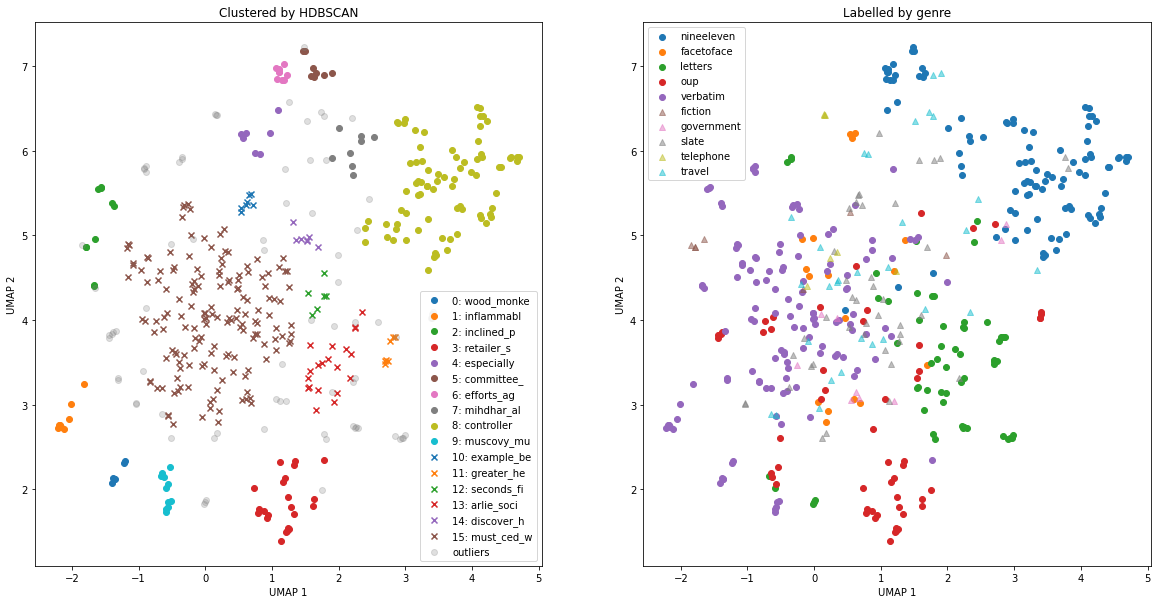

In [20]:
plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# LEFT PLOT: scatter plot of umap embeddings with clusterer labels as colors

x_plot, y_plot = selected_outlier_subset_embeddings_umap[:, 0], selected_outlier_subset_embeddings_umap[:, 1]
plt.subplot(1, 2, 1)
for i, topic in enumerate(np.unique(cluster_labels)):
    if topic != -1:
        if i > 10:
            marker = "x"
        else:
            marker = "o"
        x, y = x_plot[cluster_labels == topic], y_plot[cluster_labels == topic]
        label = "_".join([vlist[idx] for idx in top_idx[topic, :]])
        # Truncate label to fit in legend
        label = label[:10]
        plt.scatter(x, y, label=f"{topic}: {label}", marker=marker)

# outliers in gray with lower alpha
plt.scatter(x_plot[cluster_labels == -1], y_plot[cluster_labels == -1], label="outliers", color="gray", alpha=0.25)
plt.title("Clustered by HDBSCAN")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()


# RIGHT PLOT: scatter plot of umap embeddings with genre labels as colors

plt.subplot(1, 2, 2)
genre_labels = np.array([labels_dict.get(x, 0) for x in selected_outlier_subset["genre"]])
for i, genre in enumerate(labels_dict.keys()):
    x, y = x_plot[genre_labels == i], y_plot[genre_labels == i]
    if genre in mismatched_labels:
        plt.scatter(x, y, label=genre)
    else:
        plt.scatter(x, y, label=genre, alpha=0.5, marker="^")
plt.title("Labelled by genre")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()

#### Summary
- encode text examples with such models to retrieve high quality embeddings using a BERT Transformer
- reduce its dimensionality using UMAP to obtain better performance in density based clustering
- perform density based clustering on the reduced embeddings using HDBSCAN
- apply outlier detection to select unsual/anomalous examples for topic identification and modelling using c-TF-IDF